In [62]:
!pip install transformers

In [7]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 17.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 8.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 17.9 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [4]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 4.0 MB/s eta 0:00:000:00:01m eta 0:00:01


In [26]:
import pandas as pd
import transformers
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import re
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
#from pandas_profiling import ProfileReport
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import  Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import numpy as np

In [2]:
print(torch.__version__)
print(transformers.__version__)

1.13.1+cu117
4.26.1


In [27]:
pd.set_option('display.max_colwidth', None)

In [28]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [29]:
df_train.sample(2)

id   keyword       location  \
5036  7180  mudslide            NaN   
3851  5480    flames  Asheville, NC   

                                                                  text  target  
5036     British bake off was great pretty hilarious moments #mudslide       0  
3851  My Gang Walking Round With Them Brown Flames.  &amp; Thats 100ND       0

In [30]:
df_train.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

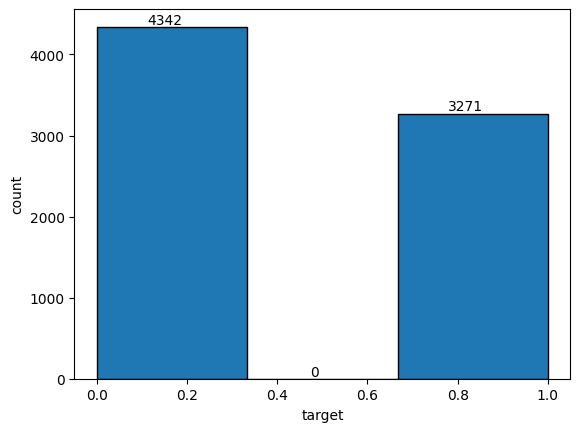

In [31]:
counts, bins, _ = plt.hist(df_train['target'], bins=3, edgecolor='black')

#print(_)
# add text to each bar
for i in range(len(counts)):
   # print(i)
    plt.text(bins[i]+0.15, counts[i]+0.5, int(counts[i]), ha='center', va='bottom')

# set the x and y axis labels
plt.xlabel('target')
plt.ylabel('count')

# display the plot
plt.show()


In [32]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [33]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [34]:
profile = ProfileReport(df_train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

NameError: name 'ProfileReport' is not defined

In [35]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [36]:
# drop location data
clean_train = df_train.drop(columns="location")
clean_test = df_test.drop(columns="location")

In [37]:
clean_train.sample(10)

id            keyword  \
3142   4516          emergency   
6950   9972            tsunami   
494     716           attacked   
5405   7715          panicking   
3030   4351         earthquake   
6813   9760            trapped   
6441   9216  suicide%20bombing   
7133  10217            volcano   
4449   6331            hostage   
6854   9823             trauma   

                                                                                                                                              text  \
3142                                  @newyorkcity for the #international emergency medicine conference w/ Lennox Hill hospital and #drjustinmazur   
6950                                                    Crptotech tsunami and banks.\n http://t.co/KHzTeVeDja #Banking #tech #bitcoing #blockchain   
494                                                                                 Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SOUTHERN MY)   
5405                                                                       it's 11:30 and I'm already panicking and crying bc I'm so stressed NICE   
3030  #3Novices : Renison mine sees seismic event http://t.co/2i4EOGGO5j A small earthquake at Tasmania's Renison tin project has created a temÛ_   
6813                                                                                                       @almusafirah_ you feel trapped innit ??   
6441                                                                                             bout to go suicide bombing http://t.co/ZoIPkPBD6o   
7133             Eruption of Indonesian volcano sparks transport chaos: In this picture done from video Mount Raung inÛ_ http://t.co/7muG2kAhL7 ?   
4449     Nearly 35 years after their release from captivity legislation is being introduced in Congress to compensate 53Û_ http://t.co/NCjLXzFWaa   
6854         Photo: lavenderpoetrycafe: The Forgotten History of Sexual Trauma Hysteria was an affliction seen primarily... http://t.co/U2eS0Uk1u3   

      target  
3142       0  
6950       1  
494        1  
5405       0  
3030       1  
6813       0  
6441       1  
7133       1  
4449       0  
6854       1

In [38]:
clean_train.shape

(7613, 4)

222 unique words in the keyword column for train data.


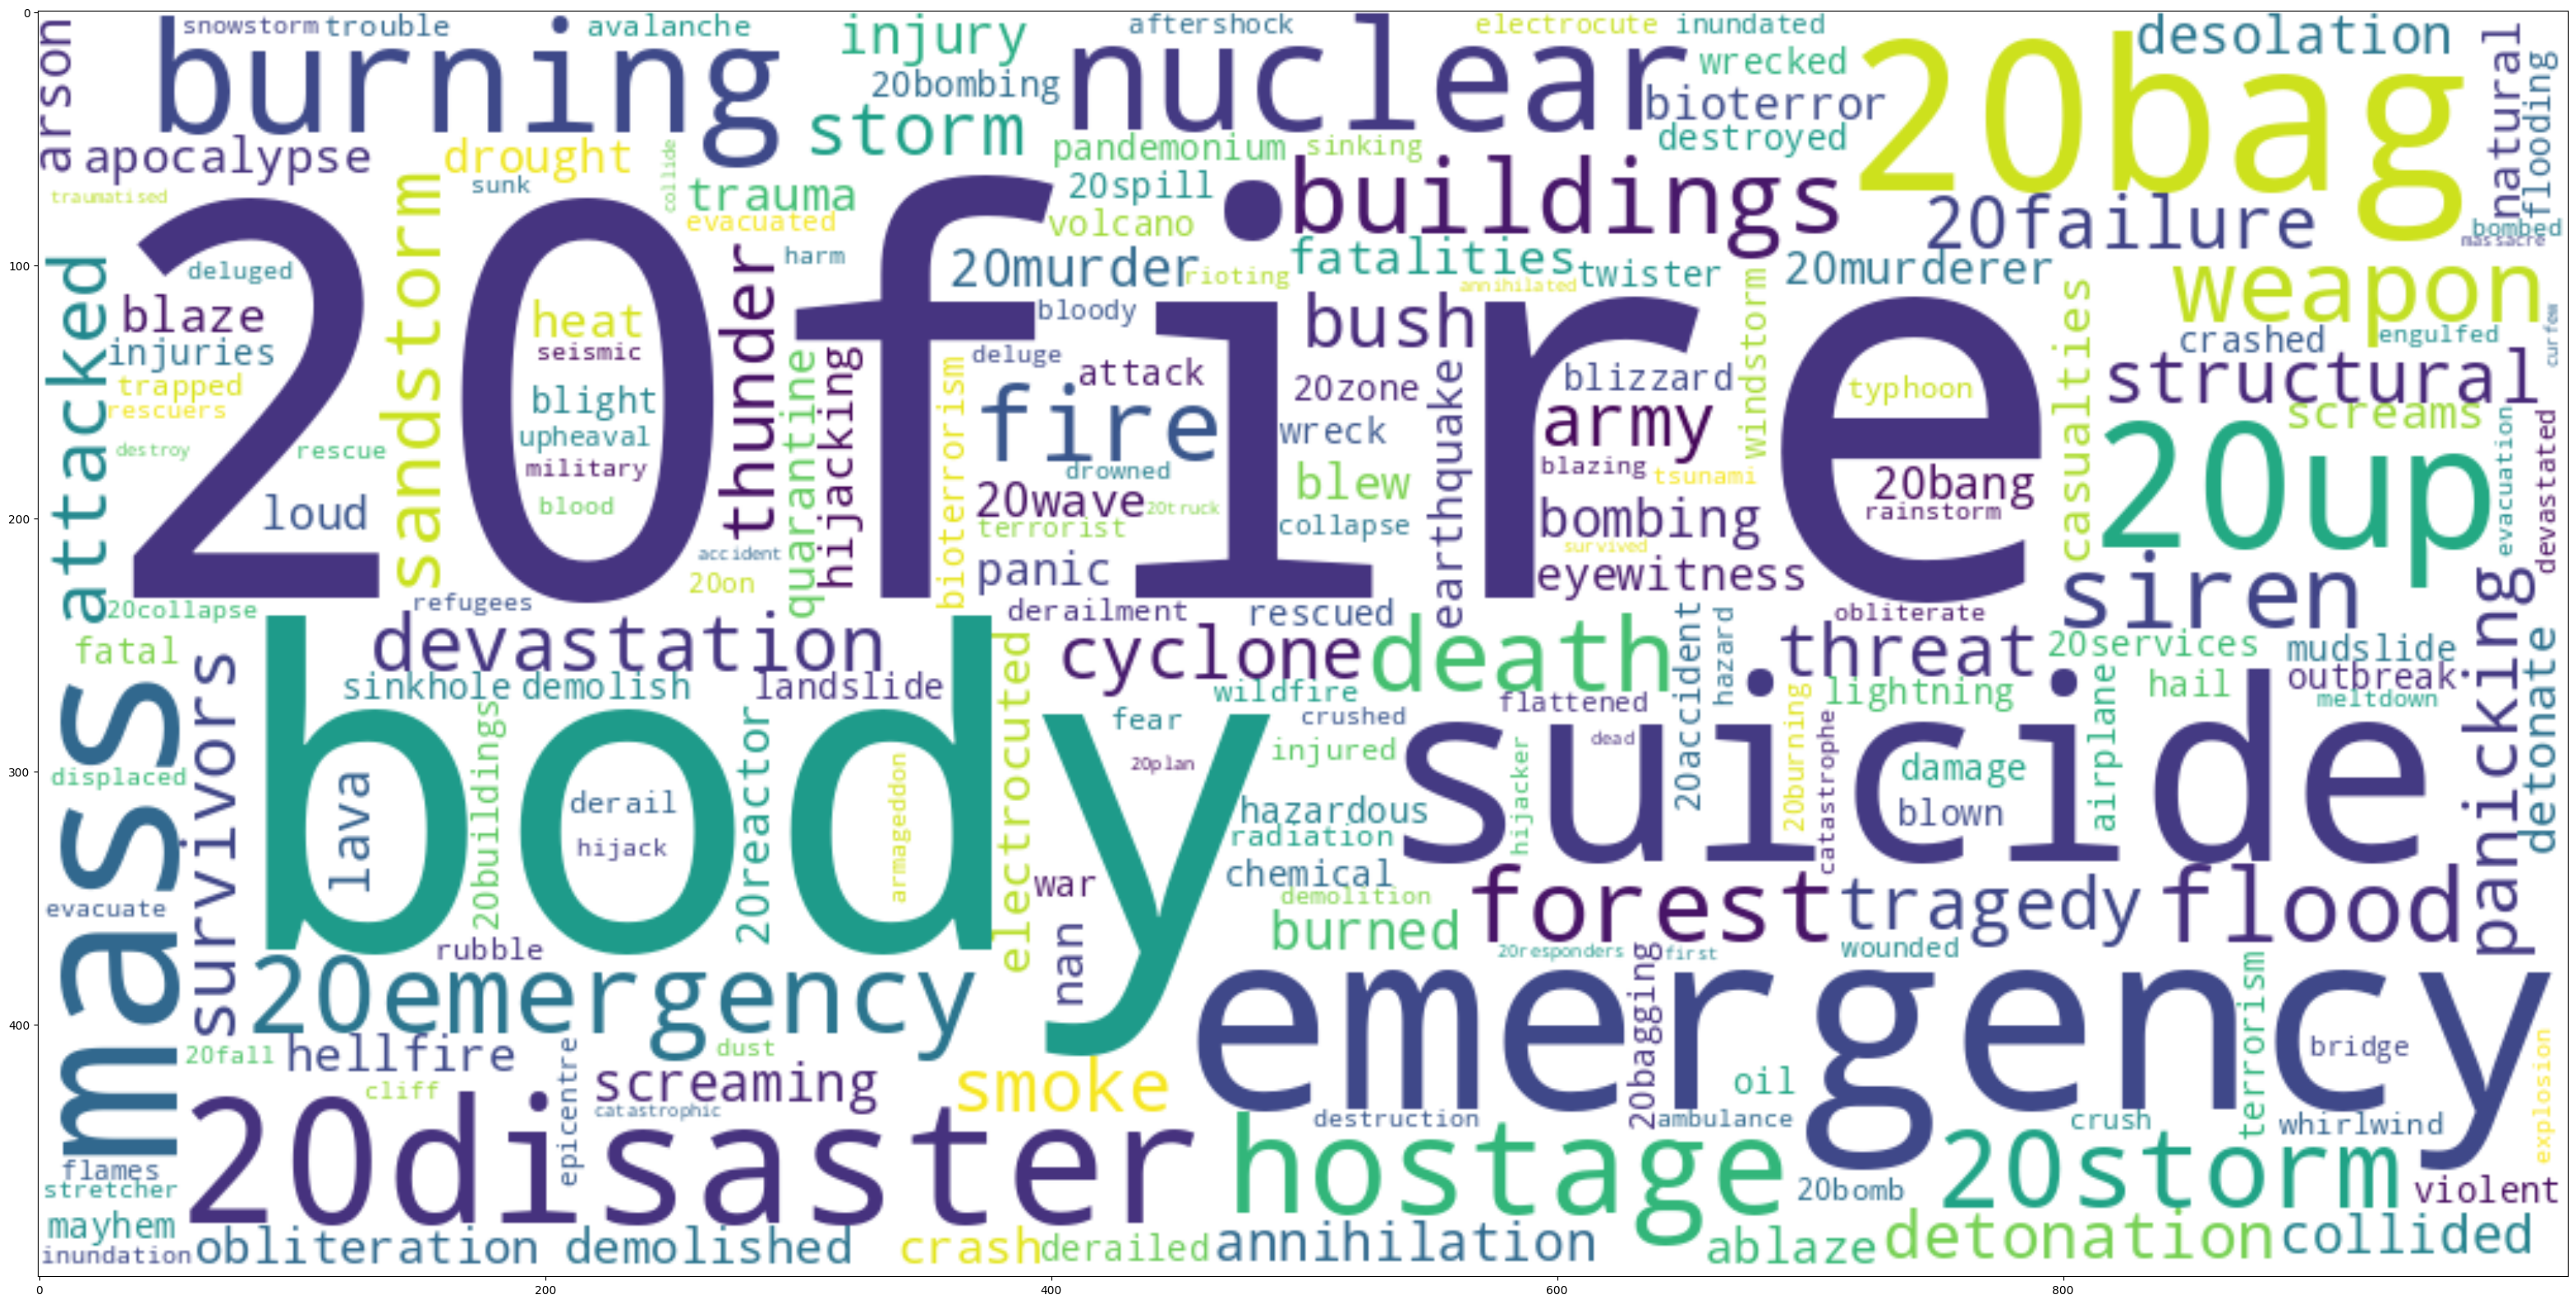

In [39]:
text = " ".join(set(word for word in clean_train['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for Test data.


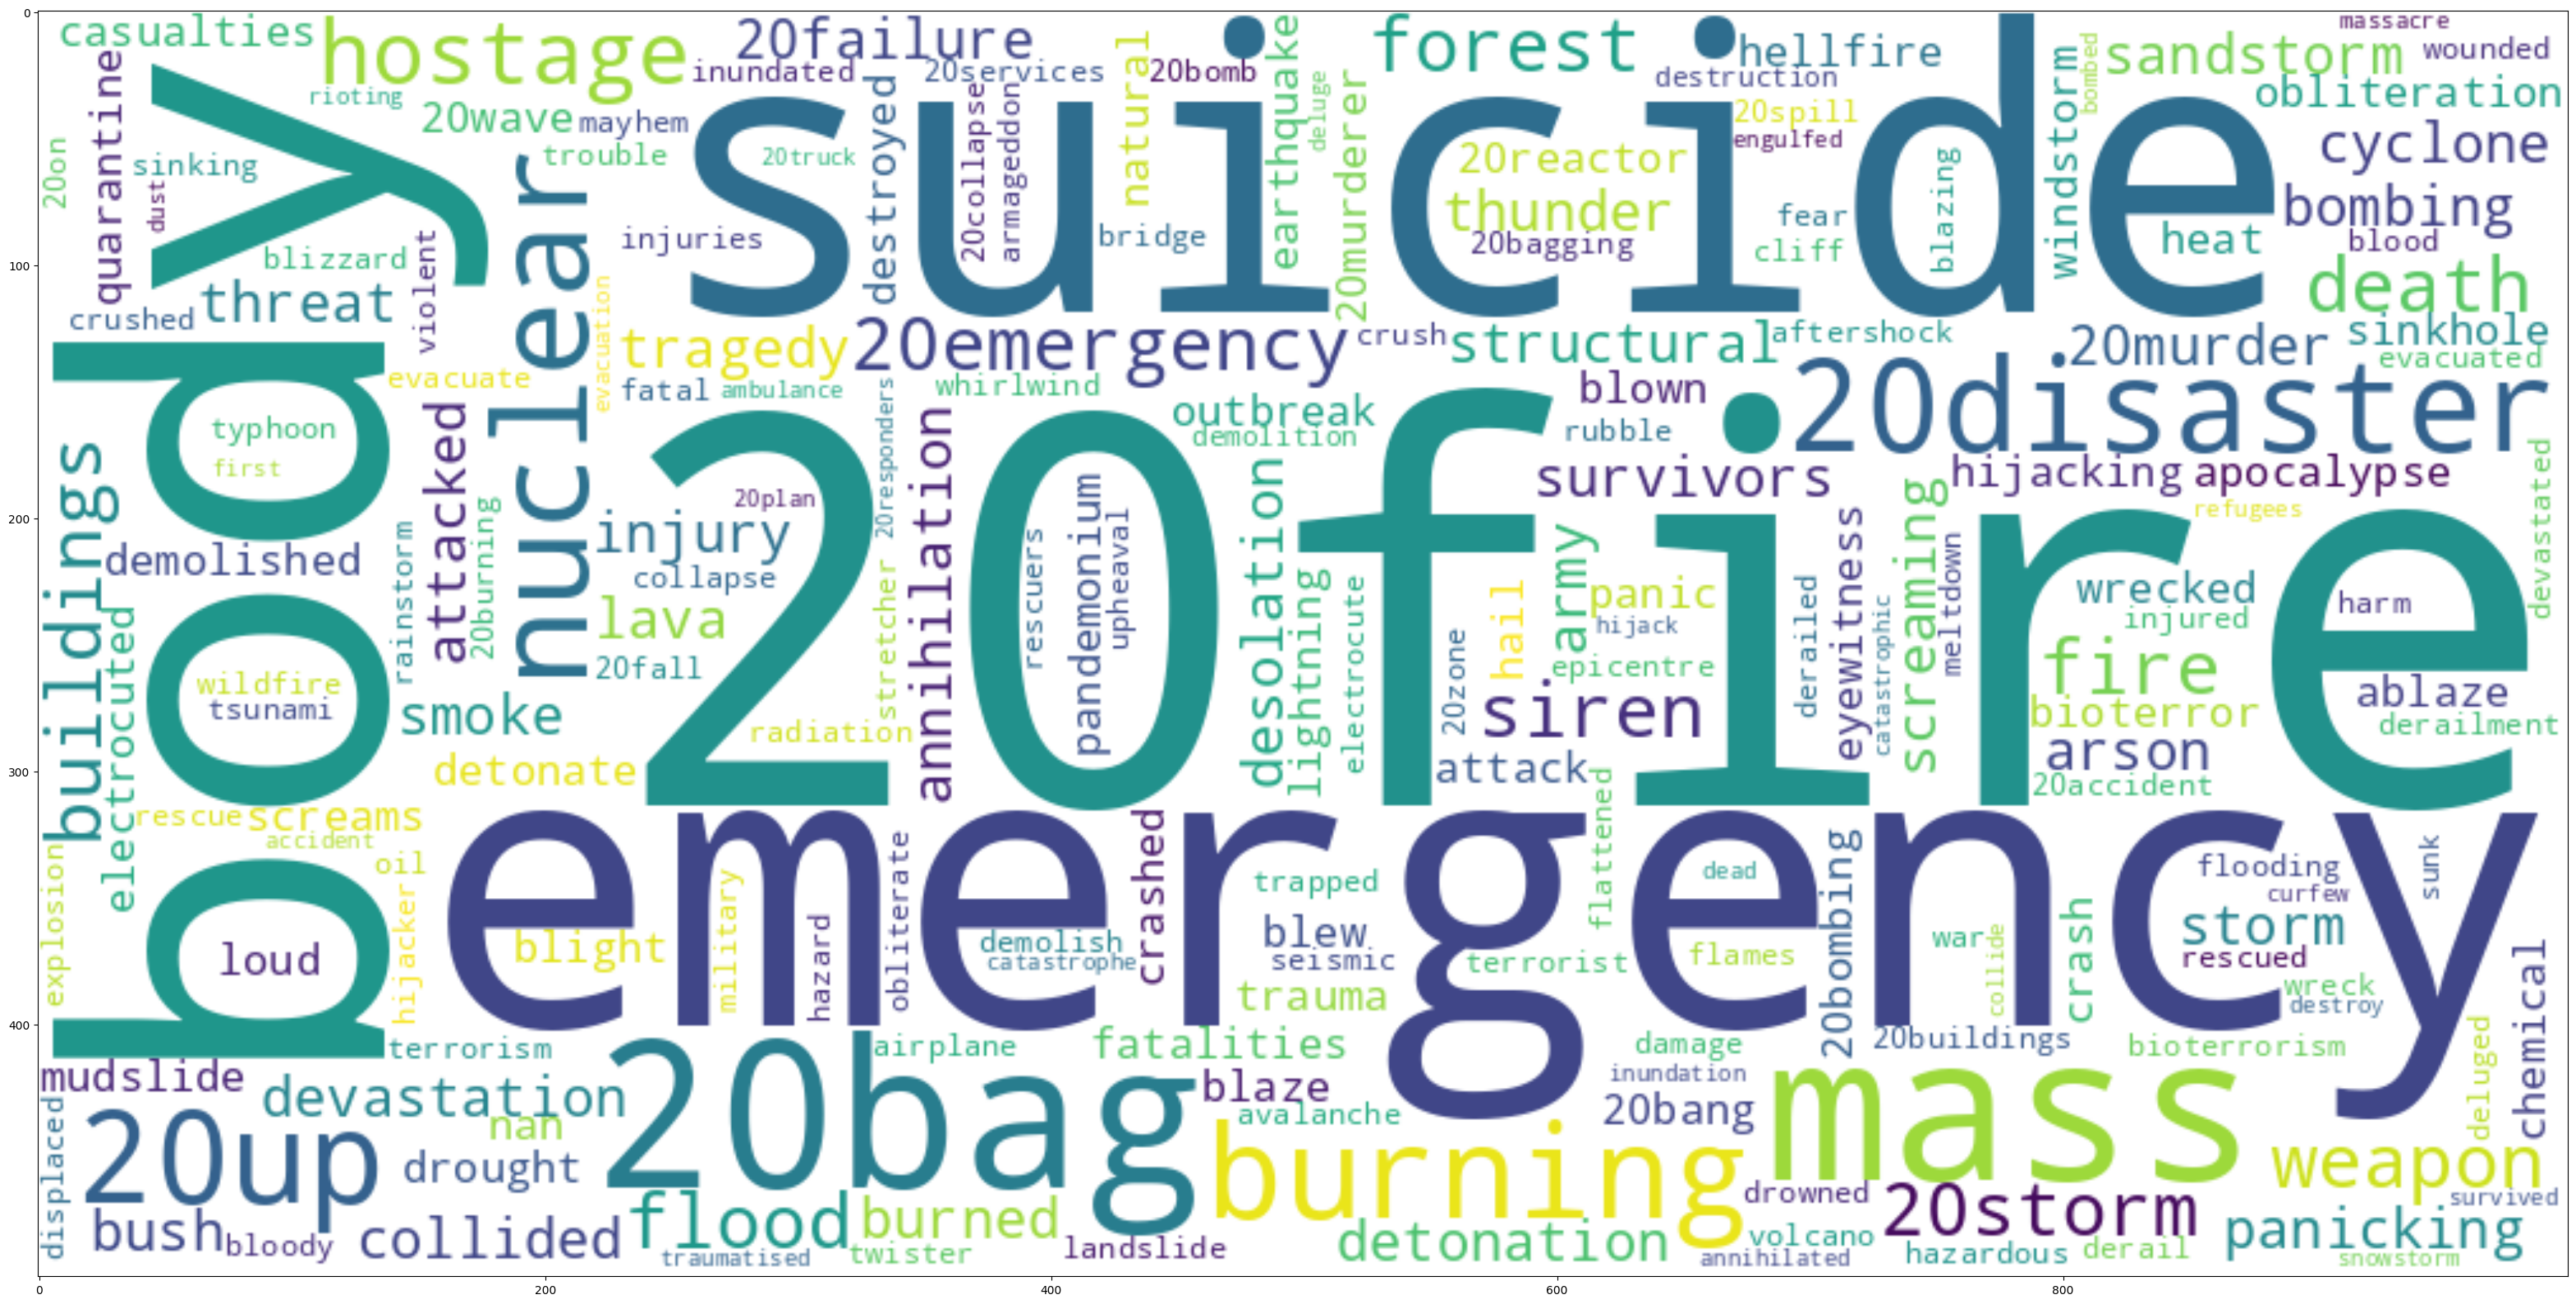

In [40]:
text = " ".join(set(word for word in clean_test['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for Test data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [41]:
clean_train = clean_train.dropna(subset=['keyword']).reset_index(drop=True)

In [42]:
# we fill none into the Nan Values, to give 0 sentiment
clean_test['keyword'] = clean_test['keyword'].fillna("None")

In [43]:
clean_train

id  keyword  \
0        48   ablaze   
1        49   ablaze   
2        50   ablaze   
3        52   ablaze   
4        53   ablaze   
...     ...      ...   
7547  10830  wrecked   
7548  10831  wrecked   
7549  10832  wrecked   
7550  10833  wrecked   
7551  10834  wrecked   

                                                                                                             text  \
0                                                         @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C   
1                                             We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw   
2                              #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi   
3                                                                              Crying out for more! Set me ablaze   
4                                    On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N   
...                                                                                                           ...   
7547                                                             @jt_ruff23 @cameronhacker and I wrecked you both   
7548  Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one   
7549                #FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM   
7550     @engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO   
7551                             Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4   

      target  
0          1  
1          0  
2          1  
3          0  
4          0  
...      ...  
7547       0  
7548       0  
7549       0  
7550       0  
7551       0  

[7552 rows x 4 columns]

In [44]:
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)

In [45]:
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_nondupes.sample(2)

id  \
text                                                                                           
:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube      1   
Market News: Activision Blizzard Cognizant Technology First Solar http://t.co/gkNRP0e8Qs   1   

                                                                                          keyword  \
text                                                                                                
:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube           1   
Market News: Activision Blizzard Cognizant Technology First Solar http://t.co/gkNRP0e8Qs        1   

                                                                                          target  
text                                                                                              
:StarMade: :Stardate 3: :Planetary Annihilation:: http://t.co/I2hHvIUmTm via @YouTube          1  
Market News: Activision Blizzard Cognizant Technology First Solar http://t.co/gkNRP0e8Qs       1

In [46]:
# check for duplicates using groupby
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes.rename(columns={'id':'# of duplicates', 'target':'sum of target var'})

# of duplicates  \
text                                                                                                                                                           
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                              2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                                       3   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                         6   
To fight bioterrorism sir.                                                                                                                                 4   
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                                6   
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                                     2   
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE                3   
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect                 3   
wowo--=== 12000 Nigerian refugees repatriated from Cameroon                                                                                                2   
RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG                                                             2   
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4                     4   
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...                                                                       2   
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption                                      3   
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring                                                                   3   
Caution: breathing may be hazardous to your health.                                                                                                        2   
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????                                                                         2   
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                          4   
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                                         2   

                                                                                                                                             keyword  \
text                                                                                                                                                   
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                      2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                               1   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                 1   
To fight bioterrorism sir.                                                                                                                         1   
He came to a land which was 

In [47]:
clean_train = clean_train.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [48]:
clean_train.sample(2)

id    keyword  \
1410  2108   casualty   
6190  9028  stretcher   

                                                                                                                                          text  \
1410  .@stavernise: France agreed to repay Russia for two warships which were never delivered after economic sanctions  http://t.co/K4H8cq7puo   
6190                                               Mxaaaa South Africans Just Can't Appreciate Effort #Stretcher Was Not That Bad  Stop Hating   

      target  
1410       0  
6190       0

In [49]:
# we save these as pickles
clean_train.to_pickle("pickles/clean_train_data.pkl")
clean_test.to_pickle("pickles/clean_test_data.pkl")

In [50]:
# download pickles
train_df = pd.read_pickle("pickles/clean_train_data.pkl")
test_df = pd.read_pickle("pickles/clean_test_data.pkl")

In [51]:
def clean_text(text):
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # remove unicode characters
    text =text.encode('ascii', 'ignore').decode()
    # Remove URLs
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'http*\S+', ' ', text)
    
    return text

In [52]:

train_df['cleaned_text'] = train_df.text.apply(clean_text)
test_df['cleaned_text'] = test_df.text.apply(clean_text)

In [53]:
list(train_df['cleaned_text'].sample(20))


['lakeeffect snowstorm twill denim jackets all my proceeds for items with this design will go_  ',
 'i feel like deathholy molys',
 'more than 40 families affected by the fatal outbreak of legionnaires disease in edinburgh are to sue two comp  ',
 'recently met with the to discuss race relations in america amp the benefits of rioting loveislove  ',
 'visting georgina at the drowned rat cafeawful view  ',
 'next may ill be freefrom school from obligations like family best of all that damn curfew',
 'just got engulfed in a carinduced tidal wave on my run i thought this only happened in the movies',
 'rgj truck trailer catches fire in reno  ',
 'the worst part is seeing lightning and trying to guess when the thunder will crack',
 'deliver value a cash source crash course   course  ',
 'everyday is a near death fatality for me on the road thank god is on my side',
 'policylab is at s last public hearing in nyc today and tomorrow to address child abuse and neglect fatalities  ',
 'i wonder 

In [31]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

# save labels
train_labels = final_train_df['target']

# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']

In [32]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [33]:
token_lens = []
for txt in list(train_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

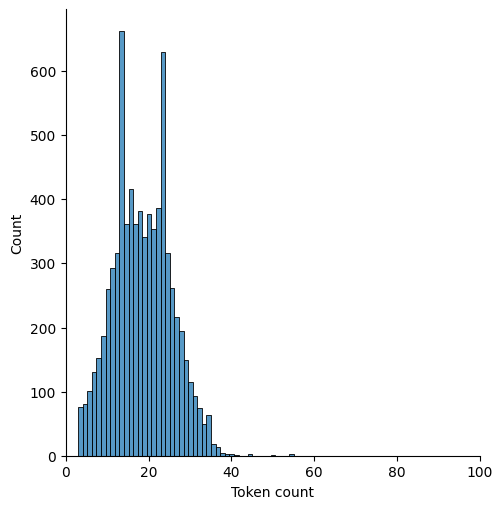

In [36]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.show()

In [37]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=55,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [38]:
max_length=55
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    train_attn_mask_list.append(attn_mask.numpy())

In [39]:
# test data tokenization
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    test_attn_mask_list.append(attn_mask.numpy())

In [40]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

In [42]:
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(train_tokenised_text_df, train_labels, train_attn_mask_list, test_size=0.3, random_state=42)

In [43]:
print(f'X_train input shape {X_train.shape} X_test input shape {X_test.shape}\nTrain label \
shape {y_train.shape} Test label shape {y_test.shape}')

X_train input shape (5212, 55) X_test input shape (2235, 55)
Train label shape (5212,) Test label shape (2235,)


In [44]:
num_classes = len(train_labels.unique())

In [49]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

checkpoint_path = "../models/light_tf_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [50]:
history=bert_model.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=2,
                       validation_data=(X_test, y_test),
                       callbacks=[model_callback])

Epoch 1/2
163/163 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7713
Epoch 1: saving model to ../models/light_tf_bert.ckpt
163/163 [==============================] - 928s 6s/step - loss: 0.4890 - accuracy: 0.7713 - val_loss: 0.4356 - val_accuracy: 0.8085
Epoch 2/2
163/163 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8548
Epoch 2: saving model to ../models/light_tf_bert.ckpt
163/163 [==============================] - 963s 6s/step - loss: 0.3638 - accuracy: 0.8548 - val_loss: 0.4150 - val_accuracy: 0.8336


In [ ]:
# checkpoint_path = "../models/light_tf_bert.ckpt"
# trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
# trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [51]:
test_pred = bert_model.predict(X_test)
print(test_pred)

70/70 [==============================] - 96s 1s/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 0.23138005, -0.9692189 ],
       [-2.2578669 ,  1.3775111 ],
       [-2.185058  ,  1.261258  ],
       ...,
       [-1.5835105 ,  0.2416105 ],
       [ 1.4172198 , -1.5870942 ],
       [ 0.16271955, -0.8163428 ]], dtype=float32), hidden_states=None, attentions=None)


In [54]:
# use softmax on logits
tensor_test_predictions = tf.math.softmax(test_pred.logits, axis=1)
print(tensor_test_predictions)

tf.Tensor(
[[0.7686313  0.23136866]
 [0.02569625 0.97430366]
 [0.03087891 0.9691212 ]
 ...
 [0.13882051 0.8611795 ]
 [0.9527687  0.04723136]
 [0.72692215 0.2730779 ]], shape=(2235, 2), dtype=float32)


In [56]:
# then use argmax after softmax to turn into labels
test_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions, axis=1).numpy()]


In [57]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

0.8335570469798658


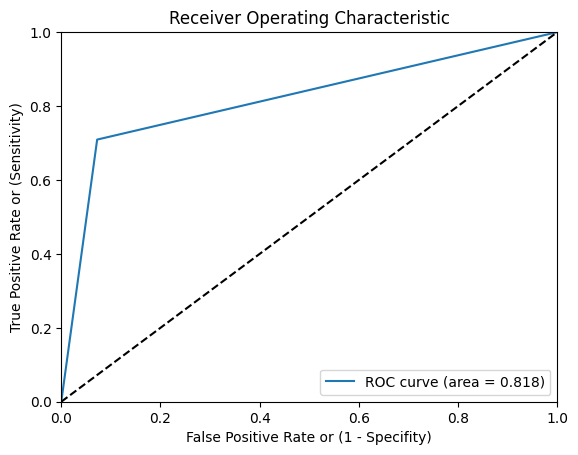

              precision    recall  f1-score   support

not disaster       0.81      0.93      0.86      1272
    disaster       0.88      0.71      0.79       963

    accuracy                           0.83      2235
   macro avg       0.84      0.82      0.82      2235
weighted avg       0.84      0.83      0.83      2235



In [66]:
eval_model(test_predictions)